In [1]:
from astropy.io import fits
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
data_list = open('WTTS_fitsfiles.txt')
content = data_list.read()
content_list = content.split('\n')
data_list.close()

hdul = []

for i in range(len(content_list)):
    hdul.append(fits.open(content_list[i]))
    
flux = np.zeros(shape=(len(content_list),800,800)) 

for i in range(len(content_list)):
    data = hdul[i][0].data
    data = np.array(data)[:,0][0,:]
    data *= 1000
    flux[i] = data 
    

In [3]:
WTTS_names = open('WTTS_names.txt')
WTTS_names_read = WTTS_names.read()
WTTS_names_list = WTTS_names_read.split('\n')
WTTS_names.close()

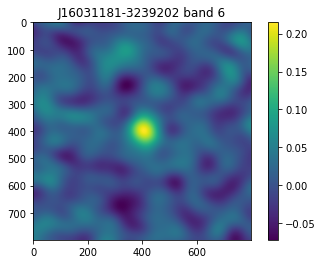

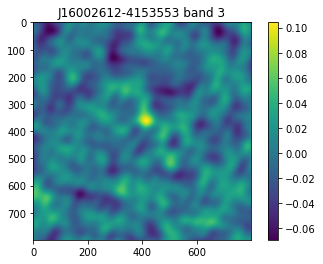

['J-323_band6.fits', 'J-332_band6.fits', 'J-365_band6.fits', 'J-390_band3.fits', 'J-390_band6.fits', 'J-401_band6.fits', 'J-415_band3.fits', 'J-415_band6.fits']
['J1603_band6', 'J1601_band6', 'J1616_band6', 'J1608_band3', 'J1608_band6', 'J1623_band6', 'J1600_band3', 'J1600_band6']


In [4]:
plt.imshow(flux[0])
plt.colorbar()
plt.title('J16031181-3239202 band 6')
plt.show()

plt.imshow(flux[6])
plt.colorbar()
plt.title('J16002612-4153553 band 3')
plt.show()

print(content_list)
print(WTTS_names_list)

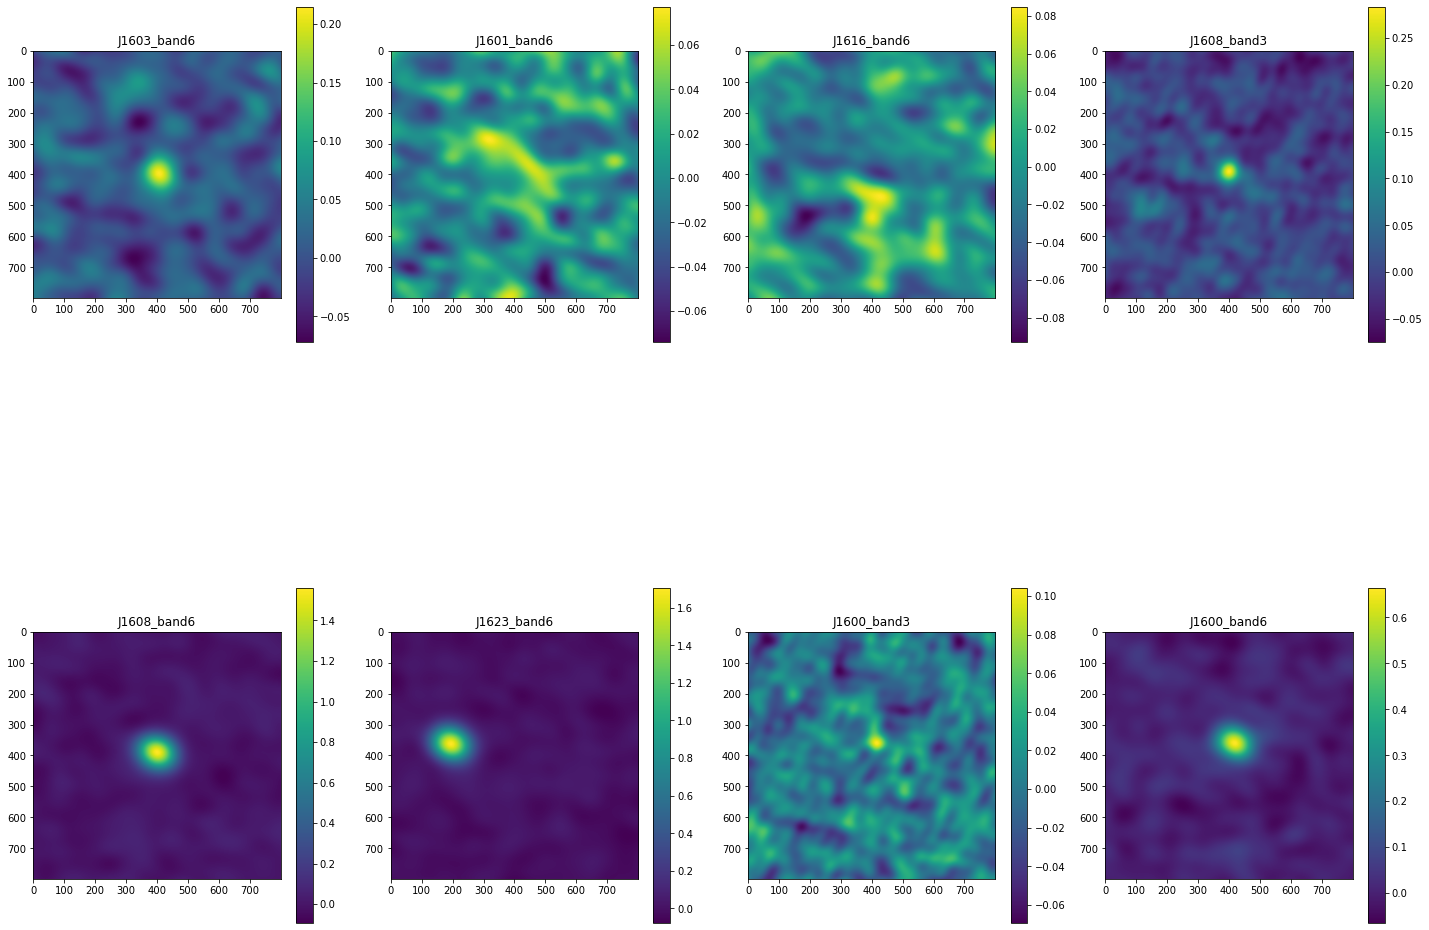

In [5]:
fig, axs = plt.subplots(2,4,figsize=(20, 20))

for i in range(len(content_list)):
    if i < 4:
        axs[0,i].imshow(flux[i])
        axs[0,i].set_title(WTTS_names_list[i])
        plt.colorbar(axs[0,i].imshow(flux[i]), ax=axs[0,i], shrink=0.4)
    else:
        axs[1,i-4].imshow(flux[i])
        axs[1,i-4].set_title(WTTS_names_list[i])
        plt.colorbar(axs[1,i-4].imshow(flux[i]), ax=axs[1,i-4], shrink=0.4)
        
fig.tight_layout()
plt.show()

In [6]:
print(np.std(flux[1])) #the two non-detections
print(np.std(flux[2])) #checks out with the values obtained from taking the whole area! 

0.02413169432836787
0.027918023207613996


In [7]:
def round_log(number):
    total = np.log10(number)
    power = np.floor(total)
    remainder = total - power 
    prefactor = round(10**remainder,2)
    return prefactor,power

def B_nu(T,nu):
    return 2*(nu**(2))*k_B*T*c_inv2*joules_to_jy

def M_dust(F_nu,d,kappa,B_nu):
    return gram_to_earthmass * (F_nu * d**2) / (kappa * B_nu)

In [8]:
k_B = 1.380649e-23
c = 3e8
c_inv2 = 1/c * 1/c
joules_to_jy = 1e26 #1 joule is 10^26 Jy

print(B_nu(20,221.5e9))
print(round_log(B_nu(20,221.5e9)))
print(round_log(B_nu(20,97.5e9)))


30105665066.77778
(3.01, 10.0)
(5.83, 9.0)


In [9]:
distances = np.array([132.9,187.0,1.984e4,159.3,159.3,9.08e3,163.2,163.2])
pc_to_cm = 3.085677e18
distances *= pc_to_cm

#print(WTTS_names_list)
flux_densities = np.array([1.658e-4,0,0,1.870e-4,2.84e-4,1.40567e-3,4.02e-5,7.465e-5]) #0 for the non-detections
frequencies = np.array([221.5,221.5,221.5,97.5,221.5,221.5,97.5,221.5]) * 1e9
kappa_nu = (frequencies/100) / 1e9 

flux_maxes = np.array([0.22e-3,0,0,0.28e-3,1.56e-3,1.71e-3,0.10e-3,0.66e-3]) #test to use this for the dust masses

gram_to_solmass = 5.027652e-34 #1/2e33
gram_to_earthmass = 1/(5.972e27) #converting grams to earth masses (useful for disks)

dust_masses = np.zeros(shape=8)
for i in range(len(distances)):
    dust_masses[i] = M_dust(flux_densities[i],distances[i],kappa_nu[i],B_nu(20,frequencies[i])) #zero means no detection
    print('the disk mass of',WTTS_names_list[i],'is',round(dust_masses[i],2),'Earth mass')


the disk mass of J1603_band6 is 0.07 Earth mass
the disk mass of J1601_band6 is 0.0 Earth mass
the disk mass of J1616_band6 is 0.0 Earth mass
the disk mass of J1608_band3 is 1.33 Earth mass
the disk mass of J1608_band6 is 0.17 Earth mass
the disk mass of J1623_band6 is 2770.86 Earth mass
the disk mass of J1600_band3 is 0.3 Earth mass
the disk mass of J1600_band6 is 0.05 Earth mass


In [170]:
DM_test = dust_masses[dust_masses != 0]
DM_test = np.delete(DM_test,3)
print(DM_test)
print(np.mean(DM_test),np.std(DM_test))

[0.07001541 1.33026962 0.17230944 0.30014622 0.04753673]
0.3840554845519758 0.48146949840006836


In [171]:
from astropy.io.votable import parse
votable_J1600 = parse("vizier_votable_J1600.vot")
table_J1600 = votable_J1600.get_first_table()

J1600_fluxes_jy = table_J1600.array['sed_flux'] #fluxes in Jy
J1600_frequencies = table_J1600.array['sed_freq'] #GHz
J1600_wavelengths = (c / (J1600_frequencies * 1e9)) * (1e6) #convert from GHz to micrometer
J1600_fluxes_Wm2 = J1600_fluxes_jy * J1600_frequencies * 1e9 * 1e-26 #fluxes in W/m^2

votable_J1603 = parse("vizier_votable_J1603.vot")
table_J1603 = votable_J1603.get_first_table()

J1603_fluxes_jy = table_J1603.array['sed_flux'] #fluxes in Jy
J1603_frequencies = table_J1603.array['sed_freq'] #GHz
J1603_wavelengths = (c / (J1603_frequencies * 1e9)) * (1e6) #convert from GHz to micrometer
J1603_fluxes_Wm2 = J1603_fluxes_jy * J1603_frequencies * 1e9 * 1e-26 #fluxes in W/m^2

votable_J1608 = parse("vizier_votable_J1608.vot")
table_J1608 = votable_J1608.get_first_table()

J1608_fluxes_jy = table_J1608.array['sed_flux'] #fluxes in Jy
J1608_frequencies = table_J1608.array['sed_freq'] #GHz
J1608_wavelengths = (c / (J1608_frequencies * 1e9)) * (1e6) #convert from GHz to micrometer
J1608_fluxes_Wm2 = J1608_fluxes_jy * J1608_frequencies * 1e9 * 1e-26 #fluxes in W/m^2

In [172]:
wtts_sources = ['J1600_b6','J1600_b3','J1603_b6','J1608_b6','J1608_b3']
casa_values_wavelength = np.array([1354,3077,1354,1354,3077])
casa_values_fluxmax = np.array([0.66e-3,0.10e-3,0.22e-3,1.56e-3,0.28e-3]) 

casa_values_fluxmax[0], casa_values_fluxmax[2], casa_values_fluxmax[3] = casa_values_fluxmax[0]*221.5e9*1e-26,\
casa_values_fluxmax[2]*221.5e9*1e-26, casa_values_fluxmax[3]*221.5e9*1e-26

casa_values_fluxmax[1], casa_values_fluxmax[4] = casa_values_fluxmax[1]*97.5e9*1e-26, casa_values_fluxmax[4]*97.5e9*1e-26

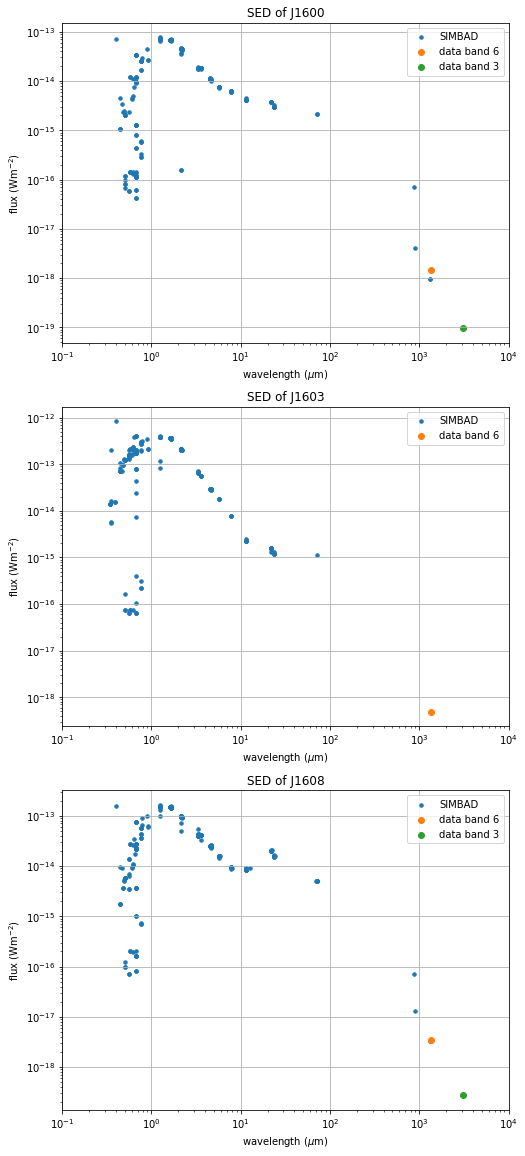

In [169]:
fig, axs = plt.subplots(3,1,figsize=(8,20))
axs[0].grid(zorder='1')
axs[0].scatter(J1600_wavelengths,J1600_fluxes_Wm2,s=12,label='SIMBAD')
axs[0].scatter(casa_values_wavelength[0],casa_values_fluxmax[0],label='data band 6')
axs[0].scatter(casa_values_wavelength[1],casa_values_fluxmax[1],label='data band 3')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim([0.1,1e4])
axs[0].set_xlim([0.1,1e4])
axs[0].set_xlabel('wavelength ($\mu$m)')
axs[0].set_ylabel('flux (Wm$^{-2}$)')
axs[0].legend()
axs[0].set_title('SED of J1600')

axs[1].grid()
axs[1].scatter(J1603_wavelengths,J1603_fluxes_Wm2,s=12,label='SIMBAD')
axs[1].scatter(casa_values_wavelength[2],casa_values_fluxmax[2],label='data band 6')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlim([0.1,1e4])
axs[1].set_xlim([0.1,1e4])
axs[1].set_xlabel('wavelength ($\mu$m)')
axs[1].set_ylabel('flux (Wm$^{-2}$)')
axs[1].legend()
axs[1].set_title('SED of J1603')

axs[2].grid()
axs[2].scatter(J1608_wavelengths,J1608_fluxes_Wm2,s=12,label='SIMBAD')
axs[2].scatter(casa_values_wavelength[3],casa_values_fluxmax[3],label='data band 6')
axs[2].scatter(casa_values_wavelength[4],casa_values_fluxmax[4],label='data band 3')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlim([0.1,1e4])
axs[2].set_xlim([0.1,1e4])
axs[2].set_xlabel('wavelength ($\mu$m)')
axs[2].set_ylabel('flux (Wm$^{-2}$)')
axs[2].set_title('SED of J1608')
axs[2].legend()
plt.show()